In [1]:
# Load required packages
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import scipy
import os
import threading
import multiprocessing
import pickle
import keras
import matplotlib.pyplot as plt
import librosa

print "Packages loaded"


Using TensorFlow backend.


Packages loaded


In [2]:
### Functions for feature extraction
class arayi(object):
    def __init__(self):
        pass
        
    # Get list of tracks for extraction
    def getTrackList(self,pathToTrack,listBool,trackName):
        if listBool == False:
            self.filelist=[]
            with open(pathToTrack+"/metadata/perfs.csv","r") as perfData:
                perfData.next()
                for line in perfData:
                    line=line.split(",")
                    tName,language=line[2].replace("_"," ").lstrip().rstrip(),line[6].rstrip()
                    if (tName == trackName and language == "EN"):
                        self.filelist.append(line[1])
            return self.filelist
        else:
            self.filelist = os.listdir(pathToTrack)            
            return self.filelist

    def getLabelList(self,pathToTrack,listBool,trackName):
        if listBool == False:
            self.filelist=[]
            with open(pathToTrack+"/metadata/perfs.csv","r") as perfData:
                perfData.next()
                for line in perfData:
                    line=line.split(",")
                    if (line[2].replace("_"," ").lstrip().rstrip() == trackName and line[6].rstrip() == "EN"):
                        self.filelist.append(line[5])
            return self.filelist
        else:
            self.filelist = os.listdir(pathToTrack)            
            return self.filelist
        
    def getTracksAndLabels(self,pathtoTrack,listBool,trackName):
        self.dataDict={}
        if listBool == False:
            with open(pathToTrack+"/metadata/perfs.csv","r") as perfData:
                perfData.next()
                for line in perfData:
                    line=line.split(",")
                    if (line[2].replace("_"," ").lstrip().rstrip() == trackName and line[6].rstrip() == "EN"):
                        self.dataDict[line[1]]=line[5]
            return self.dataDict
        else:
            self.filelist=[]
            self.filelist = os.listdir(pathToTrack)            
            return self.filelist
        
    # Extract Melodic Contours from Dataset
    def extractMelody(self, pathToTrack,trackList):
        self.extractStatus = 0.0
        pathToTrack = pathToTrack+"raw/"
        # Extracts contour for a track snd saves output for each track
        for track in trackList:
            self.trackOut = "/Users/nus/singability_data/contours/%s.yml" % track.split(".")[0]
            os.system("essentia_streaming_predominantpitchmelodia %s %s" % (pathToTrack+track+".m4a", self.trackOut))
            if float(trackList.index(track)+1)/len(trackList) > self.extractStatus:
                print "Extracting...%s %% complete." % (self.extractStatus*100)
                self.extractStatus += 0.33
                
    def cleanTrack(self,labelList):
        df = pickle.load(open("/Users/nus/singability_data/letItGo.pkl","rb"))
        df=df.transpose()
        self.lList=[]
        for col in df:
            numNull=df[col].isnull().sum()
            if numNull > 60:
                df.drop(col,1,inplace=True)
                self.lList.append(col)
        df.fillna(0)
        labelList=[x for i,x in enumerate(labelList) if i not in lList]
        return (df,labelList)

    def makeContourDataframe(self,pathToContours):
        cList=os.listdir(pathToContours)
        self.contourMatrix = {}
        for contour in cList:
            if ".yml" not in contour:
                continue
            x=list(open(pathToContours+contour,"r"))
            x=map(float,x[7].lstrip().replace("pitch: ","").replace("[","").replace("]","").split(","))
            self.contourMatrix[contour.replace(".yml","")]=x
        df = pd.DataFrame.from_dict(self.contourMatrix,orient="index")
        return df

    def excludeDataframeTracks(self,theDf,window,lList,tList):
        indexes=[]
        for col in theDf:
            numNull=theDf[col].isnull().sum()
            if numNull > window:
                theDf.drop(col,1,inplace=True)
                indexes.append(col)
        for index in sorted(indexes, reverse=True):
            del lList[index]
        for index in sorted(indexes, reverse=True):
            del tList[index]             
        return theDf
    
    def normalizeDataframe(self,theDf):
        self.x = theDf.values
        self.min_max_scaler = preprocessing.MinMaxScaler()
        self.x_scaled = self.min_max_scaler.fit_transform(self.x)
        theDf = pd.DataFrame(self.x_scaled)
        return theDf

    def displayContour(self,theDf,contourIndex):
        pass
    
a = arayi()

In [3]:
## Threaded feature extraction - Needs work

'''
NUM_WORKERS = 4
processes = [multiprocessing.Process(target=a.extractMelody(pathToTrack,tList)) for _ in range(NUM_WORKERS)]
print "Starting Process"
[process.start() for process in processes]
print "Joining process"
[process.join() for process in processes]
'''

def threadMelodyExtract(self,pathToTrack,trackList):
    ##TODO: Threading locks
    threads = []
    t=[]
    for track in trackList:
        if ".m4a" not in track or "_" not in track:
            continue
        t = threading.Thread(target=a.extractMelody, args=(pathToTrack,track,))
        threads.append(t)
        if len(threads) > 9:
            t.start()
            t.join()
            t=[]
            threads=[]

# def threadMelodyExtract2(self,pathToTrack,trackList):
#     ##TODO: Threading locks
#     lock = threading.Lock()
#     threads = []
#     for track in trackList:
#         if ".m4a" not in track or "_" not in track:
#             continue
#         t = threading.Thread(target=a.extractMelody, args=(pathToTrack,track,))
#         lock.acquire()
#         if not lock.acquire(False):
#             print "Fail"
#         else:
#             try:
#                 t.start()
#                 t.join()
#         finally:
#             lock.release()
            
# arayi.threadMelodyExtract = threadMelodyExtract
# arayi.threadMelodyExtract2 = threadMelodyExtract2

In [ ]:
# Run Functions
pathToTrack = "/Users/nus/singability_data/"
a = arayi()

songs=["let it go","stay rihanna"]

# tracksAndLabels=a.getTracksAndLabels(pathToTrack,False,"let it go")
# lList=tracksAndLabels.values()
# tList=tracksAndLabels.keys()
# plt.scatter(x=range(0,len(tracksAndLabels)),y=np.log(sorted(map(float,tracksAndLabels.values()))),s=1)
# plt.show()

# a.extractMelody(pathToTrack, tracksAndLabels.keys())
# songDf,songLabels = a.cleanTrack(lList)

# df = a.makeContourDataframe("/Users/nus/singability_data/contours/stay/")
# df.to_csv("/Users/nus/Documents/Github/Singability/data/stay.csv", sep='\t')
df=pd.read_csv("/Users/nus/Documents/Github/Singability/data/letItGo.csv",sep="\t")
df=df.transpose()
# df

df = a.excludeDataframeTracks(df,60,lList,tList)
# df
df=df.replace(0, np.NaN)
# dfNorm = a.normalizeDataframe(df)

# x=dfNorm.index.values.tolist()
# y=dfNorm[0].tolist()

x=df.index.values.tolist()
y=df[0].tolist()

plt.scatter(x,y,s=.1)
plt.show()

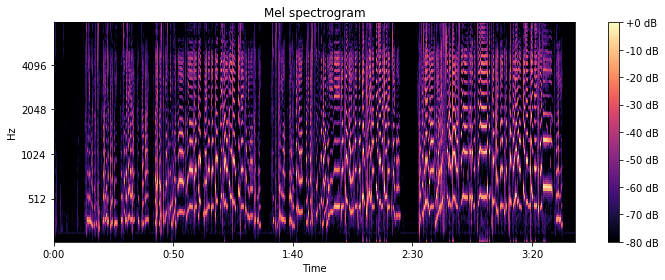

In [14]:
from scipy.io import wavfile
from scipy.fftpack import fft
import librosa
from librosa import display

myAudio="/Users/nus/Desktop/68366569_39548661_1.wav"

y, sr = librosa.load(myAudio)
librosa.feature.melspectrogram(y=y, sr=sr)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()